# Python: Potential Quantiles
In this example, we illustrate how the [DoubleML](https://docs.doubleml.org/stable/index.html) package can be used to estimate local potential quantiles and quantile treatment effects. The estimation is based on the article from [Kallus  et al.](https://arxiv.org/abs/1912.12945)

## Data
We define a data generating process to create synthetic data to compare the estimates to the true effect.

In [2]:
import numpy as np
import pandas as pd
import doubleml as dml
import multiprocessing

from sklearn.ensemble import RandomForestClassifier

The data is generated similar to in [Kallus et al.](https://arxiv.org/abs/1912.12945)



In [3]:
def f_loc(D, X, X_conf):
  loc = 0.3*D + 4*D*X[:,4]*2*X[:,1] - 3*X[:,3] - 2*X_conf[:,0]
  return loc

def f_scale(D,X, X_conf):
  scale = np.sqrt(0.5*D + 3*D*X[:,1] + 1)
  return scale

def generate_treatment(Z,X,X_conf):
    eta = np.random.normal(size=len(Z))
    d = ((1.5*Z + 0.0*X_conf[:,0] + eta) > 0)*1.0
    return d

def dgp(n=200, p=5):
    X = np.random.uniform(0,1,size=[n,p])
    X_conf = np.random.uniform(-1,1,size=[n,4])
    Z = np.random.binomial(1, p=0.5, size=n) #norm.cdf(3*(1 - X[:, 0] - X[:, 3]))
    D = generate_treatment(Z,X, X_conf)
    epsilon = np.random.normal(size=n)

    Y = f_loc(D, X, X_conf) + f_scale(D, X, X_conf)*epsilon

    return Y, X, D, Z

We can calculate the true potential quantile analytically or through simulations. Here, we will just simulate the true quantile for a range of quantiles.

In [7]:
tau_vec = np.arange(0.2,0.9,0.1)
#tau_vec = [0.3, 0.5, 0.7]
p = 5
n_true = int(10e+6)

n_cores = multiprocessing.cpu_count()
print(f"Number of Cores: {n_cores}")

Number of Cores: 8


In [8]:
X_true = np.random.uniform(0,1,size=[n_true,p])
X_conf_true = np.random.uniform(-1, 1, size=[n_true,4])
Z_true = np.random.binomial(1, p=0.5, size=n_true) #norm.cdf(3*(1 - X[:, 0] - X[:, 3]))
eta_true = np.random.normal(size=n_true)
D1_true = generate_treatment(np.ones_like(Z_true),X_true, X_conf_true)
D0_true = generate_treatment(np.zeros_like(Z_true),X_true, X_conf_true)
epsilon_true = np.random.normal(size=n_true)

compliers = (D1_true == 1) * (D0_true == 0)
print(f'Compliance probability: {str(compliers.mean())}')
n_compliers = compliers.sum()
Y1 = f_loc(np.ones(n_compliers), X_true[compliers, :], X_conf_true[compliers, :]) + f_scale(np.ones(n_compliers), X_true[compliers, :], X_conf_true[compliers, :])*epsilon_true[compliers]
Y0 = f_loc(np.zeros(n_compliers), X_true[compliers, :], X_conf_true[compliers, :]) + f_scale(np.zeros(n_compliers), X_true[compliers, :], X_conf_true[compliers, :])*epsilon_true[compliers]

Compliance probability: 0.4668292


In [9]:
Y0_quant = np.quantile(Y0, q=tau_vec)
Y1_quant = np.quantile(Y1, q=tau_vec)

print(f'LPQ Y(0): {Y0_quant}')
print(f'LPQ Y(1): {Y1_quant}')
print(f'LQTE: {Y1_quant- Y0_quant}')

LPQ Y(0): [-3.03053834 -2.45868133 -1.9642565  -1.49932585 -1.03488048 -0.54068665
  0.02794568]
LPQ Y(1): [-1.6297591  -0.81434152 -0.09310595  0.60682111  1.33316945  2.14408716
  3.13973817]
LQTE: [1.40077924 1.64433981 1.87115055 2.10614696 2.36804994 2.68477381
 3.11179249]


Let us generate $n=500$ observations and convert them to a [DoubleMLData](https://docs.doubleml.org/stable/api/generated/doubleml.DoubleMLData.html) object.

In [10]:
n = 5000
p = 5
Y, X, D, Z = dgp(n=n,p=p)
obj_dml_data = dml.DoubleMLData.from_arrays(X, Y, D, Z)

Next, we can initialize our two machine learning algorithms to train the different classifiers. Then we can initialize the `DoubleMLPQ` objects and call `.fit()` to estimate the relevant parameters. To obtain confidence intervals, we can use the `.confint()` method.

In [11]:
ml_m = RandomForestClassifier(n_estimators=100)

LPQ_0 = np.full((len(tau_vec)), np.nan)
LPQ_1 = np.full((len(tau_vec)), np.nan)

ci_LPQ_0 = np.full((len(tau_vec),2), np.nan)
ci_LPQ_1 = np.full((len(tau_vec),2), np.nan)

for idx_tau, tau in enumerate(tau_vec):
    print(f'Quantile: {tau}')

    dml_LPQ_1 = dml.DoubleMLLPQ(obj_dml_data,ml_m,
                              score="LPQ",
                              treatment=1,
                            quantile=tau,
                              n_folds=5,
                              trimming_threshold=0.05)
    dml_LPQ_1.fit(n_jobs_cv=n_cores-1)

    ci_LPQ_1[idx_tau, :] = dml_LPQ_1.confint(level=0.95).to_numpy()
    LPQ_1[idx_tau] = dml_LPQ_1.coef

    dml_PQ_0 = dml.DoubleMLLPQ(obj_dml_data, ml_m,
                              score="LPQ",
                              treatment=0,
                               quantile=tau,
                              n_folds=5,
                              trimming_threshold=0.05)
    dml_PQ_0.fit(n_jobs_cv=n_cores-1)

    ci_LPQ_0[idx_tau, :] = dml_PQ_0.confint(level=0.95).to_numpy()
    LPQ_0[idx_tau] = dml_PQ_0.coef



Quantile: 0.2
Quantile: 0.30000000000000004
Quantile: 0.4000000000000001
Quantile: 0.5000000000000001
Quantile: 0.6000000000000001
Quantile: 0.7000000000000002
Quantile: 0.8000000000000003


Finally, let us take a look at the estimated quantiles.

In [12]:
data = {"Quantile": tau_vec, "Y(0)": Y0_quant, "Y(1)": Y1_quant,
        "DML Y(0)": LPQ_0, "DML Y(1)": LPQ_1,
        "DML Y(0) lower": ci_LPQ_0[:, 0], "DML Y(0) upper": ci_LPQ_0[:, 1],
        "DML Y(1) lower": ci_LPQ_1[:, 0], "DML Y(1) upper": ci_LPQ_1[:, 1]}
df = pd.DataFrame(data)
print(df)

   Quantile      Y(0)      Y(1)  DML Y(0)  DML Y(1)  DML Y(0) lower  \
0       0.2 -3.030538 -1.629759 -3.043337 -1.496549       -3.239045   
1       0.3 -2.458681 -0.814342 -2.473067 -0.853695       -2.705648   
2       0.4 -1.964257 -0.093106 -1.976533 -0.320281       -2.165403   
3       0.5 -1.499326  0.606821 -1.527742  0.729281       -1.738032   
4       0.6 -1.034880  1.333169 -1.030239  1.477481       -1.259673   
5       0.7 -0.540687  2.144087 -0.604025  2.274534       -0.874079   
6       0.8  0.027946  3.139738  0.054025  3.061925       -0.303564   

   DML Y(0) upper  DML Y(1) lower  DML Y(1) upper  
0       -2.847630       -1.872231       -1.120868  
1       -2.240487       -1.218444       -0.488946  
2       -1.787664       -0.689193        0.048631  
3       -1.317452        0.088651        1.369912  
4       -0.800806        0.942826        2.012137  
5       -0.333971        1.868796        2.680272  
6        0.411614        2.498864        3.624985  


Text(0.02, 0.5, 'Potential Quantile and 95%-CI')

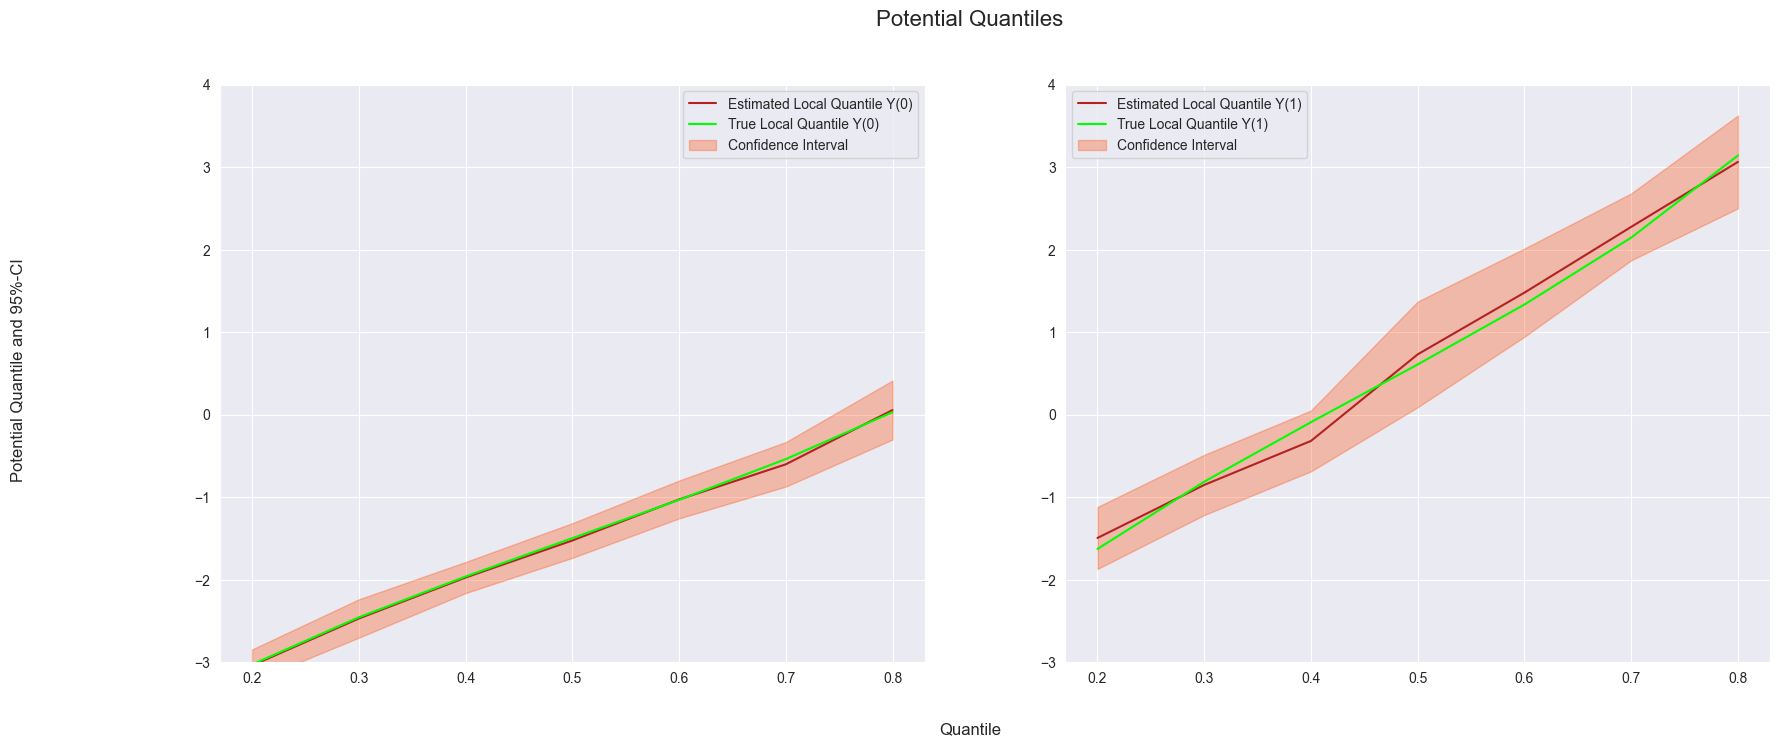

In [13]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 20., 7.5
fig, (ax1, ax2) = plt.subplots(1 ,2)

ax1.plot(df['Quantile'],df['DML Y(0)'], color="firebrick", label='Estimated Local Quantile Y(0)')
ax1.plot(df['Quantile'],df['Y(0)'], color="lime", label='True Local Quantile Y(0)')
ax1.fill_between(df['Quantile'], df['DML Y(0) lower'], df['DML Y(0) upper'], color='orangered', alpha=.3, label='Confidence Interval')
ax1.legend()
ax1.set_ylim(-3, 4)

ax2.plot(df['Quantile'],df['DML Y(1)'], color="firebrick", label='Estimated Local Quantile Y(1)')
ax2.plot(df['Quantile'],df['Y(1)'], color="lime", label='True Local Quantile Y(1)')
ax2.fill_between(df['Quantile'], df['DML Y(1) lower'], df['DML Y(1) upper'], color='orangered', alpha=.3, label='Confidence Interval')
ax2.legend()
ax2.set_ylim(-3, 4)

fig.suptitle('Potential Quantiles', fontsize=16)
fig.supxlabel('Quantile')
fig.supylabel('Potential Quantile and 95%-CI')

To estimate the quantile treatment effect

In [ ]:
dml_LQTE = dml.DoubleMLQTE(obj_dml_data, ml_g=ml_m, quantiles=tau_vec, n_rep=1,
                           score='LPQ', n_jobs_cv=n_cores-1, n_folds=5)
dml_LQTE.fit()
LQTE_est = dml_LQTE.coef
print(LQTE_est)

In [ ]:
dml_LQTE.bootstrap(n_rep_boot=2000)
ci_LQTE= dml_LQTE.confint(level=0.95, joint=False).to_numpy()

In [ ]:
LQTE = Y1_quant - Y0_quant
data = {"Quantile": tau_vec, "LQTE": LQTE, "DML LQTE": LQTE_est,
        "DML LQTE lower": ci_LQTE[:, 0], "DML LQTE upper": ci_LQTE[:, 1]}
df = pd.DataFrame(data)
print(df)

In [ ]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 20., 7.5
fig, ax = plt.subplots()

ax.plot(df['Quantile'],df['DML LQTE'], color="firebrick", label='Estimated LQTE')
ax.plot(df['Quantile'],df['LQTE'], color="lime", label='True LQTE')
ax.fill_between(df['Quantile'], df['DML LQTE lower'], df['DML LQTE upper'], color='orangered', alpha=.3, label='Confidence Interval')

plt.legend()
plt.title('Local Quantile Treatment Effects', fontsize=16)
plt.xlabel('Quantile')
_ =  plt.ylabel('QTE and 95%-CI')